# Define a Sunsynchronous orbit

In [1]:
import pykep as pk
import numpy as np
import matplotlib.pyplot as plt

Define useful constants

In [2]:
p= 0.19910213e-6 #[rad/s], precession
Re=6378.1363 #[km], Earth radius
J2 = 1.08262668e-3 # precession J2 coefficient
muE= 398600.440 # [km^3/s^2], standard gravitational parameter
G = 6.7430e-11 # [m^3⋅kg−1⋅s−2], Cavendish constant
Me = 5.972e24 # [kg], Earth mass

## 1) Get (altitude, eccentricity) - altitude function

In [3]:
def get_inclination(h, e):
    # h (float): altitude in km
    # e (float): eccentricity
    return np.arccos(-2/3 * p/J2 * ((Re + h) * (1 - e*e)/Re)**2 * np.sqrt((h + Re) ** 3 / muE))* 180/np.pi

In [4]:
h=np.arange(300, 860, 10).astype(np.float64) #[km] altitude
i = get_inclination(h, 1.2e-3)

Text(0, 0.5, 'inclination [deg]')

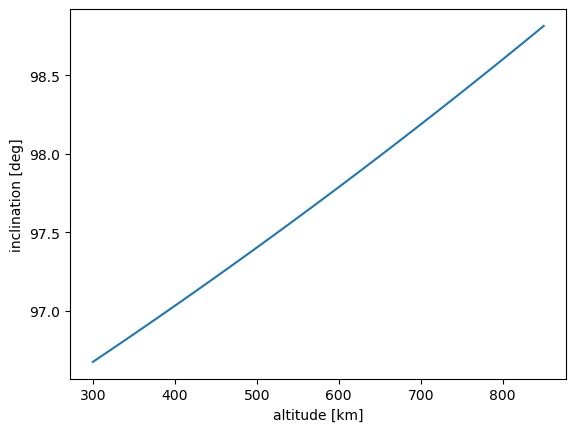

In [5]:
plt.plot(h, i)
plt.xlabel("altitude [km]")
plt.ylabel("inclination [deg]")

## 2) Fix repeating cycle constraints and get the minimum Swath width

Let's define the repeating cycle ($D$) as a function of the number of repetitions ($R$) <br> For a sun-synchronous orbit, it is true that: $$R \cdot T_N \cdot ({\omega}_e - p) = 2 \cdot \pi \cdot D$$, where p is the precession with respect to the ascending node, 
 ${\omega}_E$ is the Earth rotation rate to the vernal equinox,$D$ and $R$ are two integers prime between them and $T_N$ is the orbital period. In particular, $D$ is the number of nodal days and $R$ is the number of orbits in $D$ days.

Now, ${\omega}_e = \frac{2 * \pi}{T_{sydereal}}$, whilst ${\omega}_s = \frac{2 *\pi}{T_{synodic}}$.

You, probably, know that $T_{sydereal}=23 * 3600 + 56 * 60 + 4$ whilst $T_{synodic}=24*3600 $.<br> Therefore,  ${\omega}_e = \frac{2 * \pi}{T_{sydereal}} = \frac{2 * \pi}{T_{sydereal}} \cdot \frac{T_{synodic}}{T_{synodic}} = {\omega}_s \cdot (1 + \frac{3x60 + 4}{T_{sydereal}}) = {\omega}_s \cdot (1 + \frac{1}{365.24})$. <br> To be sunsynchronous, the satellite precission $p$ shall match as the **Earth mean motion**, which is the rotation of the **mean sun** around the Earth that is of 365.24 days. Therefore, $p = 2*\pi/(365.24 * T_{synodic}) = \frac{\omega_s}{s}.$. <br> Therefore, the equation above becomes (**Eq. 1**): <br> $$R \cdot  \frac{T_N}{T_{synodic}} = D$$ <br>You need also to consider that (**Eq. 2**): $$ a = \sqrt[3]{\mu_{E}\cdot(\frac{T_N}{2\pi})^2}$$, where is the $a=h + R_E$ is the major semi-axis. <br> So you can proceed as follows: <br> 
- Fix the repeating cycle in days $D$. 
- Then, you select a number of repetitions $R$. 
- You find the $T_N$ from Eq 1. 
- You select the altitude from Eq. 2.

Now, **minimum swath width** $S_w$ to have total coverage assuming that no titl manovers are possible, is: 

$$S_w = \frac{2\pi R_E}{R}$$, where $R_E$ is the Earth radius. So, are dividing the Earth circonference for the number of repetitions. This gives us the size of each repetition that has to be covered by the satellite across its track. 

In [6]:
def get_swath_width(D, R):
    T_synodic = 86400 # s
    T_N = T_synodic * D / R 
    a = np.cbrt(muE * (T_N/(2 * np.pi))**2)
    h = a - Re
    S_w = 2 * np.pi * Re /R
    return S_w, a, h, T_N

For instance, we try now to get [Sentinel-2](https://www.esa.int/Enabling_Support/Operations/Sentinel-2_operations) numbers.

In [7]:
D = 10 #Revisit time of a single satellite
R = 143 #14.3 orbits per day => 143 in 10 days.
S_w, a, h, T_N = get_swath_width(D, R)

In [8]:
print("altitude [km]: ", h)
print("period [minute]: ", T_N/60)
print("swath width [km]: ", S_w)

altitude [km]:  791.7315152816172
period [minute]:  100.6993006993007
swath width [km]:  280.2448411702711


## 3) How to get the orbit

To find the other orbital parameters, proceed as follow: 
- You find the select the eccentricity of the orbit 
- You find the inclination from `get_inclination(h,e)` 
- You take as date the equinotium, so the satellite is along the major-semiaxis with a distance equal to $h + R_e$.
- Then, $a = R_e + h$.
- (True anomaly) $\nu=0$.
- (Argument of perigee): $\omega = 90$
- (Longitude of ascending node): $\Omega = 270$

In [27]:
e = 1.2e-3
i = get_inclination(np.array(h), e) / 180 * np.pi
w = np.pi/2  #Argument of perigee
W = 3/2 * np.pi  # Longitude of ascending node
v = 3/2 * np.pi #True anomaly
params = [a * 1000,e,i,W, w,v]
params

[7169867.815281617,
 0.0012,
 1.720336214612357,
 4.71238898038469,
 1.5707963267948966,
 4.71238898038469]

Now you can the the ephemerides by using PASEOS.

In [28]:
r, v = pk.par2ic(params, 1)

In [29]:
params

[7169867.815281617,
 0.0012,
 1.720336214612357,
 4.71238898038469,
 1.5707963267948966,
 4.71238898038469]

In [30]:
r

(1281.8275717780234, -7169862.652974932, -8507.820199078998)

In [31]:
v

(-5.5639297673936255e-05, -8.125056621227717e-20, 0.00036929236898515695)

In [32]:
i

1.720336214612357